<a href="https://colab.research.google.com/github/felipefrocha/esufmg-evolutionary-computation/blob/master/Felipe_Rocha_Matheus_Cascalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema das N-Rainhas

### Alunos:Felipe Fonseca Rocha; Matheus Cascalho

“Dado um tabuleiro de xadrez regular (NxN) e N rainhas, posicione as N­Rainhas no tabuleiro
de forma que elas não se coloquem em xeque”


* Uma forma de representar uma solução candidata no espaço de busca do problema
* Uma função de aptidão (objetivo) para avaliar a qualidade de uma solução candidata
* Um ou mais operadores de variação
* Um ou mais mecanismos de seleção
* Uma condição de término

---

### Importação das bibliotecas

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
plt.style.use('fivethirtyeight')

### Representação da solução 

A representação de uma solução (cromossomo) é feita por um vetor que é uma iteraçãode N valores. Cada solução pode ser convertida em uma matriz que representa o tabuleiro (fenótipo). Nessa matriz, as posições ocupadas por uma raínha são preenchidas com o valor 1 e as demais com o valor 0

In [ ]:
def fenotipo(c):
    N = len(c)
    g = np.zeros((N, N))
    for i, v in enumerate(c):
        g[int(v), i] = 1        
    return g

### Função de aptidão

Uma vez que o tabuleiro é representado por uma matriz de 0's e 1's, podemos avaliar a qualidade de uma função somando o valor de suas diagonais (função np.trace()). O número de xeques será o valor da soma menos 1.

ex.: 

1 0 0

0 1 0

0 0 1

soma da diagonal = 3. Quantidade de xeques: 2.

In [ ]:
def evaluate(f):
    n_xeques = 0
        
    # Verificando diagonais principais e secundarias
    f_flip = f[:, ::-1]     
    for j in range(len(f) - 1, -1, -1):
        diag_sum = np.trace(f[j:,:len(f)-j])
        diag_flip_sum = np.trace(f_flip[j:,:len(f_flip)-j])
        if diag_sum > 1:
            n_xeques += diag_sum - 1
        if diag_flip_sum > 1:
            n_xeques += diag_flip_sum - 1
    
    for j in range(len(f) - 1, 0, -1):
        diag_sum = np.trace(f[:j,len(f) - j:])
        diag_flip_sum = np.trace(f_flip[:j,len(f_flip) - j:])
        if diag_sum > 1:
            n_xeques += diag_sum - 1
        if diag_flip_sum > 1:
            n_xeques += diag_flip_sum - 1
            
    
    
    return n_xeques

### Operadores de variação

* Crossover:

Dado um par de cromossomos pais, calcula-se um numero aleatório que será o índice para realizar o corte dos pais e os filhos serão a concatenação cruzada das partes resultantes do corte.

In [ ]:
def crossover(c1, c2):
    is_permutation = False
    while not is_permutation:
        i = random.randint(0, len(c1))
        n1 = np.concatenate((c1[:i], c2[i:]))
        n2 = np.concatenate((c1[i:], c2[:i]))
        if len(np.unique(n1)) == len(c1):
            is_permutation = True
    return np.array([n1, n2])

* Mutação:

Dado um cromossomo original, escolhe-se dois índices aleatório para realizar a troca de valores entre sí

In [ ]:
def mutation(c):
    i1 = random.randint(0, len(c) - 1)
    i2 = random.randint(0, len(c) - 1)
    while i1 == i2:
        i2 = random.randint(0, len(c) - 1)
    aux1 = c[i1]
    aux2 = c[i2]
    
    c[i1] = aux2
    c[i2] = aux1
    return c

### Operadores de seleção

* Seleção de pais:

Dada uma população de cromossomos, 5 são escolhidos aleatóriamente. Os 2 melhores avaliados são escolhidos como pais para a próxima geração

In [ ]:
def parent_selection(pop):
    id_parents = np.random.randint(0, len(pop), size=5)
    parents = []
    for i in id_parents:
        parents.append({
            'parent': pop[i],
            'val': evaluate(fenotipo(pop[i]))
        })
    parents.sort(key=lambda x: x['val'])
    parents = [p['parent'] for p in parents]
    return parents[:2]

* Seleção de sobreviventes

Dada uma população, escolhe-se dois indívídups para realizar o crossover. A partir da nova população (população inicial e 2 cromossomos filhos, todas as soluções são avaliadas. Desprezam-se os dois piores avaliados.


In [ ]:
def suvivor_selection(pop):
    rank = [{'c': c, 'val': evaluate(fenotipo(c))} for c in pop]
    rank.sort(key=lambda x: x['val'])
    new_pop = [c['c'] for c in rank]
    children = crossover(*new_pop[-2:])
    new_pop = new_pop[:-2]
    return np.concatenate((np.array(new_pop), children))

### Funções auxiliares

In [ ]:
def first_pop(size_pop, N):
    pop = []
    for p in range(size_pop):
        pop.append(random.sample(range(N), N))
    return np.array(pop)

In [ ]:
def mean_value_population(pop):
    value_vector = []
    for c in pop:
        v = evaluate(fenotipo(c))
        value_vector.append(v)
    return np.mean(value_vector)

In [ ]:
def print_matrix(m):
    s = '| '
    for i in range(0, len(m)):
        for j in range(0, len(m[i])):
            if m[i][j] == 0:
                a = ' '
            else:
                a = '$'
            s += f'{a} | '
        s += '\n' + '-'*33 + '\n| '
#     print(s[:-2])
    return s[:-2]

## Implementação do algorítmo

In [ ]:
def N_queen_problem(N, size_pop, mutation_probability, crossover_probability, max_iteration=10000, max_error=0.001):
    pop = first_pop(size_pop=size_pop, N=N)
    
    # Avaliando cada candidato
    quality_distribution = list(map(lambda x: evaluate(fenotipo(x)), pop))
    it = 0
    
    best = []
    mean = []
    diffs = []
    while min(quality_distribution) > 0 and it < max_iteration:
        # Seleção dos pais
        parents = parent_selection(pop)
        
        # Sorteando numero para crossover. O crossover irá ocorrer quando r < crossover_probability
        r = random.random()
        if r < crossover_probability:
            offspring = crossover(*parents)
        else:
            offspring = np.array([])
        if len(offspring) > 0:
            
            # Mutação dos filhos
            for o in offspring:
                # Sorteando numero para mutação. A mutação irá ocorrer quando r < mutation_probability
                r = random.random() 
                if r < mutation_probability:
                    o = mutation(o)
        new_pop = np.concatenate((pop, offspring))
        pop = suvivor_selection(new_pop)
        quality_distribution = list(map(lambda x: evaluate(fenotipo(x)), pop))
        
        best.append(min(quality_distribution))
        m = np.array(quality_distribution).mean()
        if len(mean) > 1:
            d = abs(m - mean[-1])
            diffs.append(d)
            if it > 10:
                if sum(diffs[-10:]) <= max_error:
                    print(diffs[-10:])
                    break
        mean.append(m)
        it += 1
    
    p = quality_distribution.index(min(quality_distribution))
    solution = pop[p]
    s = f'Solução:\nCromossomo: {solution}\nFenotipo:\n'
    s += print_matrix(fenotipo(solution))
    s += f'finalizado em {it} iterações'
    return solution, best, mean, s

## Testes

Solução:
Cromossomo: [6 3 1 7 5 0 2 4]
Fenotipo:
|   |   |   |   |   | $ |   |   | 
---------------------------------
|   |   | $ |   |   |   |   |   | 
---------------------------------
|   |   |   |   |   |   | $ |   | 
---------------------------------
|   | $ |   |   |   |   |   |   | 
---------------------------------
|   |   |   |   |   |   |   | $ | 
---------------------------------
|   |   |   |   | $ |   |   |   | 
---------------------------------
| $ |   |   |   |   |   |   |   | 
---------------------------------
|   |   |   | $ |   |   |   |   | 
---------------------------------
finalizado em 399 iterações


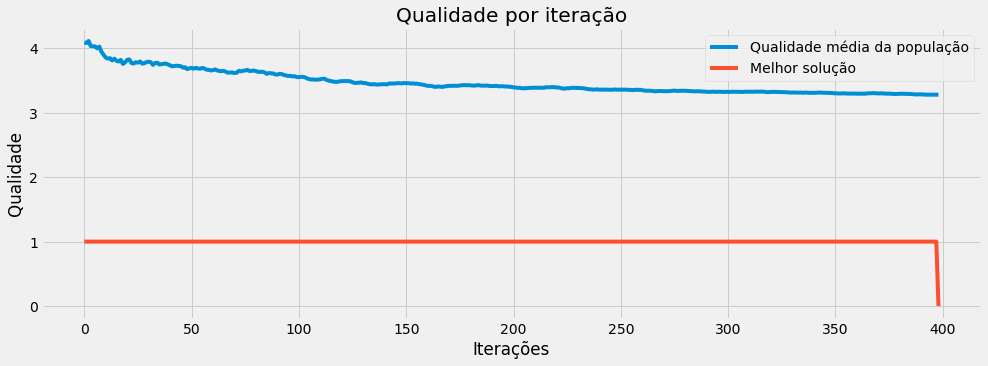

In [ ]:
c, best, mean, s = N_queen_problem(N=8, size_pop=20, mutation_probability=0.8, crossover_probability=1)

print(s)

x = np.arange(len(mean))
plt.figure(figsize=(15,5))
plt.plot(x, mean, label='Qualidade média da população')
plt.plot(x, best, label='Melhor solução')
plt.xlabel('Iterações')
plt.ylabel('Qualidade')
plt.title('Qualidade por iteração')
plt.legend();

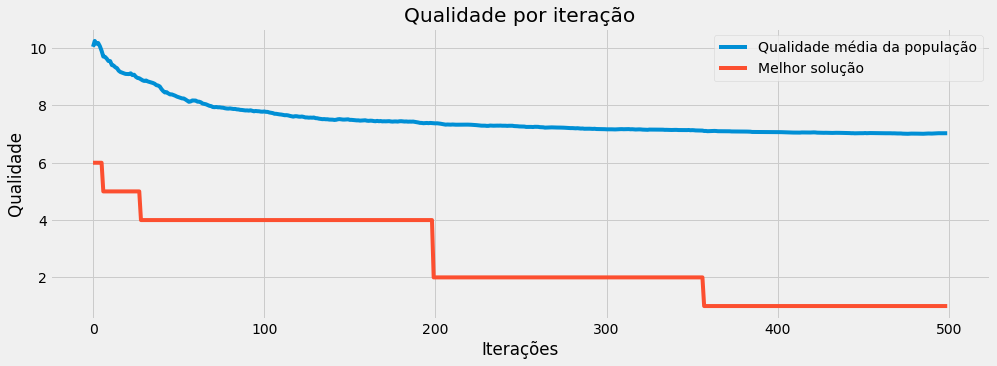

In [ ]:
c, best, mean, s  = N_queen_problem(N=20, size_pop=20, mutation_probability=0.8, crossover_probability=1, max_iteration=500)

x = np.arange(len(mean))
plt.figure(figsize=(15,5))
plt.plot(x, mean, label='Qualidade média da população')
plt.plot(x, best, label='Melhor solução')
plt.xlabel('Iterações')
plt.ylabel('Qualidade')
plt.title('Qualidade por iteração')
plt.legend();

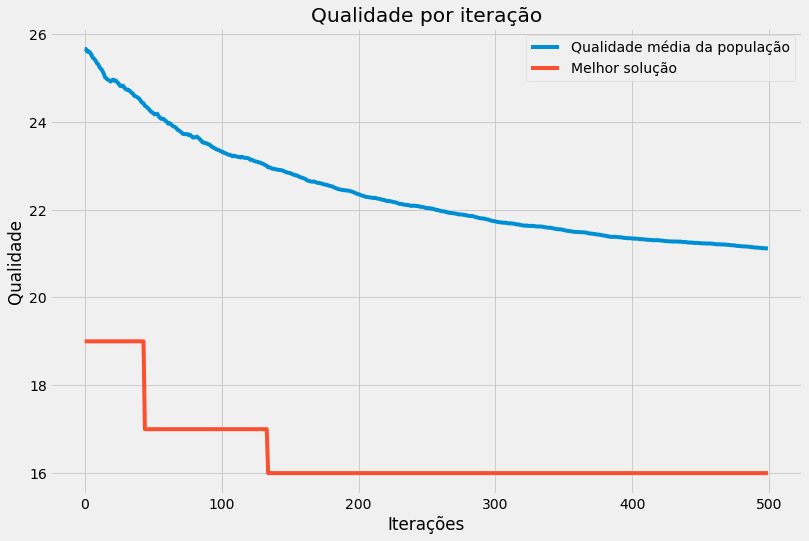

In [ ]:
c, best, mean, s = N_queen_problem(N=50, size_pop=100, mutation_probability=0.8, crossover_probability=1, max_iteration=500)

x = np.arange(len(mean))
plt.figure(figsize=(12,8))
plt.plot(x, mean, label='Qualidade média da população')
plt.plot(x, best, label='Melhor solução')
plt.xlabel('Iterações')
plt.ylabel('Qualidade')
plt.title('Qualidade por iteração')
plt.legend();